In [1]:
# 1. Bibliotekų importavimas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import requests
from datetime import datetime, timedelta

# Nustatome grafikų stilių
plt.style.use('ggplot')

In [2]:
# 2. Duomenų gavimas iš Binance API
# Ši funkcija gauna Bitcoin kainos duomenis iš Binance API

def gauti_bitcoin_duomenis(dienu_skaicius=365):
    """
    Gauna Bitcoin kainos duomenis per pasirinktą dienų skaičių iš Binance
    
    Args:
        dienu_skaicius: Kiek praeities dienų įtraukti
    
    Returns:
        pandas DataFrame su kainų duomenimis
    """
    # Apskaičiuojame pradžios laiko žymą (timestamp) milisekundėmis
    pabaigos_data = datetime.now()
    pradzios_data = pabaigos_data - timedelta(days=dienu_skaicius)
    
    # Konvertuojame į UNIX laiko žymą milisekundėmis
    pradzios_ms = int(pradzios_data.timestamp() * 1000)
    
    # Binance API URL - naudojame dienos (1d) laiko intervalą BTCUSDT simboliui
    url = "https://api.binance.com/api/v3/klines"
    
    # Parametrai užklausai
    params = {
        "symbol": "BTCUSDT",     # Bitcoin/USDT pora
        "interval": "1d",        # Dieninis intervalas
        "startTime": pradzios_ms, # Pradžios laikas
        "limit": 1000            # Maksimalus įrašų skaičius (Binance limitas)
    }
    
    print(f"Gaunami Bitcoin duomenys nuo {pradzios_data.strftime('%Y-%m-%d')} iki {pabaigos_data.strftime('%Y-%m-%d')}...")
    
    try:
        # Siunčiame užklausą į Binance API
        atsakymas = requests.get(url, params=params)
        
        # Tikriname, ar užklausa sėkminga
        if atsakymas.status_code == 200:
            duomenys = atsakymas.json()
            
            # Binance grąžina duomenis kaip sąrašą sąrašų:
            # [
            #   [OpenTime, Open, High, Low, Close, Volume, CloseTime, ...],
            #   ...
            # ]
            
            # Sukuriame DataFrame su reikiamais stulpeliais
            df = pd.DataFrame(duomenys, columns=[
                'atidarymo_laikas', 'atidarymo_kaina', 'auksciausia', 'zemiausia', 
                'uzdarymo_kaina', 'apyvarta', 'uzdarymo_laikas', 'apyvarta_quote', 
                'sandoriu_skaicius', 'aktyvaus_pirkimo_apyvarta', 
                'aktyvaus_pirkimo_apyvarta_quote', 'ignoruoti'
            ])
            
            # Konvertuojame laiko žymas į datetime ir kainų stulpelius į float
            df['atidarymo_laikas'] = pd.to_datetime(df['atidarymo_laikas'], unit='ms')
            df['uzdarymo_laikas'] = pd.to_datetime(df['uzdarymo_laikas'], unit='ms')
            df['uzdarymo_kaina'] = df['uzdarymo_kaina'].astype(float)
            
            # Nustatome datą kaip indeksą
            df = df.set_index('atidarymo_laikas')
            
            # Išrenkame tik uždarymo kainą ir pervadinkime stulpelį
            bitcoin_df = df[['uzdarymo_kaina']].copy()
            bitcoin_df = bitcoin_df.rename(columns={'uzdarymo_kaina': 'kaina'})
            
            print(f"Sėkmingai gauti {len(bitcoin_df)} dienų duomenys.")
            return bitcoin_df
            
        else:
            print(f"Klaida gaunant duomenis iš Binance. Statusas: {atsakymas.status_code}")
            print(f"Atsakymas: {atsakymas.text}")
            return None
            
    except Exception as e:
        print(f"Klaida: {str(e)}")
        return None

# Gauname duomenis už pastaruosius 2 metus (730 dienų)
bitcoin_df = gauti_bitcoin_duomenis(730)

# Patikriname, kaip atrodo duomenys
bitcoin_df.head()

Gaunami Bitcoin duomenys nuo 2023-05-24 iki 2025-05-23...
Sėkmingai gauti 730 dienų duomenys.


,kaina
atidarymo_laikas,
2023-05-25,26473.79
2023-05-26,26705.92
2023-05-27,26854.27
2023-05-28,28065.00
2023-05-29,27736.40


In [3]:
# 3. Duomenų apvalymas ir ypatybių kūrimas

# Tikriname ar yra tuščios reikšmės
print("Trūkstamos reikšmės:")
print(bitcoin_df.isna().sum())

# Pašaliname eilutes su trūkstamomis reikšmėmis (jei tokių yra)
bitcoin_df = bitcoin_df.dropna()

# Sukuriame tikslo kintamąjį - ar kaina pakils (1) ar nukris (0) kitą dieną
bitcoin_df['kaina_rytoj'] = bitcoin_df['kaina'].shift(-1)  # Kainos reikšmė kitą dieną
bitcoin_df['tikslas'] = (bitcoin_df['kaina_rytoj'] > bitcoin_df['kaina']).astype(int)  # 1 jei kils, 0 jei kris

# Sukuriame keletą paprastų ypatybių (features)

# 1. Ankstesnių dienų kainų pokyčiai
bitcoin_df['pokytis_1d'] = bitcoin_df['kaina'].pct_change(1)  # Pokytis per 1 dieną
bitcoin_df['pokytis_3d'] = bitcoin_df['kaina'].pct_change(3)  # Pokytis per 3 dienas
bitcoin_df['pokytis_7d'] = bitcoin_df['kaina'].pct_change(7)  # Pokytis per 7 dienas

# 2. Slankieji vidurkiai
bitcoin_df['SMA_7'] = bitcoin_df['kaina'].rolling(window=7).mean()  # 7 dienų slankusis vidurkis
bitcoin_df['SMA_30'] = bitcoin_df['kaina'].rolling(window=30).mean()  # 30 dienų slankusis vidurkis

# 3. Kainos ir slankiojo vidurkio santykis
bitcoin_df['santykis_SMA7'] = bitcoin_df['kaina'] / bitcoin_df['SMA_7']
bitcoin_df['santykis_SMA30'] = bitcoin_df['kaina'] / bitcoin_df['SMA_30']

# 4. Papildomos techninės ypatybės

# Relative Strength Index (RSI) - santykinio stiprumo indeksas (14 dienų)
def skaiciuoti_rsi(kainos, periodas=14):
    # Apskaičiuojame kainos pokyčius
    delta = kainos.diff()
    
    # Atskirame teigiamus ir neigiamus pokyčius
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    # Apskaičiuojame vidutinį pelną ir nuostolį per periodą
    avg_gain = gain.rolling(window=periodas).mean()
    avg_loss = loss.rolling(window=periodas).mean()
    
    # Apskaičiuojame santykinį stiprumo indeksą (RS)
    rs = avg_gain / avg_loss
    
    # Apskaičiuojame RSI
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

# Sukuriame RSI ypatybę
bitcoin_df['RSI_14'] = skaiciuoti_rsi(bitcoin_df['kaina'])

# 5. Kainų svyravimų ypatybės
bitcoin_df['svyravimas_7d'] = bitcoin_df['kaina'].rolling(window=7).std() / bitcoin_df['kaina'].rolling(window=7).mean()

# Pašaliname eilutes su trūkstamomis reikšmėmis po ypatybių sukūrimo
bitcoin_df = bitcoin_df.dropna()

# Pašaliname 'kaina_rytoj' stulpelį, nes jo negalime naudoti kaip ypatybės (tai būtų ateities informacija)
bitcoin_df = bitcoin_df.drop('kaina_rytoj', axis=1)

# Patikriname, kaip atrodo paruošti duomenys
print("Duomenų rinkinio forma po paruošimo:", bitcoin_df.shape)
bitcoin_df.head()

Trūkstamos reikšmės:
kaina    0
dtype: int64
Duomenų rinkinio forma po paruošimo: (700, 11)


,kaina,tikslas,pokytis_1d,pokytis_3d,pokytis_7d,SMA_7,SMA_30,santykis_SMA7,santykis_SMA30,RSI_14,svyravimas_7d
atidarymo_laikas,,,,,,,,,,,
2023-06-23,30688.50,0,0.026889,0.084093,0.164870,28368.087143,27017.134000,1.081797,1.135890,77.314155,0.064670
2023-06-24,30527.43,0,-0.005249,0.017788,0.151240,28941.007143,27152.255333,1.054816,1.124305,82.397585,0.061701
2023-06-25,30462.66,0,-0.002122,0.019332,0.156518,29529.962857,27277.480000,1.031585,1.116770,81.451838,0.048395
2023-06-26,30267.99,1,-0.006390,-0.013703,0.127537,30019.054286,27391.270667,1.008293,1.105023,79.529856,0.026897
2023-06-27,30692.44,0,0.014023,0.005405,0.084232,30359.690000,27478.852000,1.010960,1.116948,80.569843,0.010633


In [4]:
# 4. Duomenų padalijimas į mokymo ir testavimo rinkinius

# Pasirenkame visas ypatybes išskyrus tikslo kintamąjį
X = bitcoin_df.drop('tikslas', axis=1)
y = bitcoin_df['tikslas']

# Patikriname ypatybių formą
print("Ypatybių (X) forma:", X.shape)
print("Tikslo kintamojo (y) forma:", y.shape)

# Padalijame duomenis į mokymui ir testavimui (80% mokymui, 20% testavimui)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Mokymo rinkinio dydis:", X_train.shape)
print("Testavimo rinkinio dydis:", X_test.shape)

# Patikriname klasių pasiskirstymą
print("\nKlasių pasiskirstymas visame rinkinyje:")
print(y.value_counts())
print("\nKlasių pasiskirstymas mokymo rinkinyje:")
print(y_train.value_counts())

Ypatybių (X) forma: (700, 10)
Tikslo kintamojo (y) forma: (700,)
Mokymo rinkinio dydis: (560, 10)
Testavimo rinkinio dydis: (140, 10)

Klasių pasiskirstymas visame rinkinyje:
tikslas
1    360
0    340
Name: count, dtype: int64

Klasių pasiskirstymas mokymo rinkinyje:
tikslas
1    287
0    273
Name: count, dtype: int64


In [5]:
# 5. Random Forest modelio sukūrimas ir apmokymas

# Sukuriame Random Forest modelį su numatytaisiais parametrais
# n_estimators: medžių skaičius (numatytasis - 100)
# random_state: atsitiktinių skaičių generatoriaus pradinis taškas (užtikrina rezultatų pakartojamumą)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Apmokome modelį naudodami mokymo duomenis
rf_model.fit(X_train, y_train)

print("Random Forest modelis sėkmingai apmokytas!")

# Atliekame prognozes su testavimo duomenimis
y_pred_rf = rf_model.predict(X_test)

# Apskaičiuojame modelio tikslumą
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest modelio tikslumas: {accuracy_rf:.4f}")

# Parodome išsamesnę klasifikavimo ataskaitą
print("\nKlasifikavimo ataskaita:")
print(classification_report(y_test, y_pred_rf))

Random Forest modelis sėkmingai apmokytas!
Random Forest modelio tikslumas: 0.4929

Klasifikavimo ataskaita:
              precision    recall  f1-score   support

           0       0.46      0.36      0.40        67
           1       0.51      0.62      0.56        73

    accuracy                           0.49       140
   macro avg       0.49      0.49      0.48       140
weighted avg       0.49      0.49      0.48       140



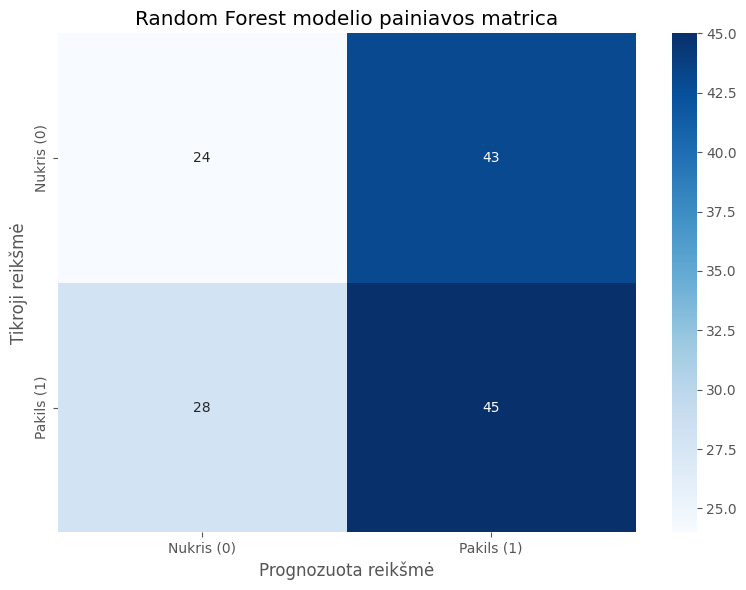

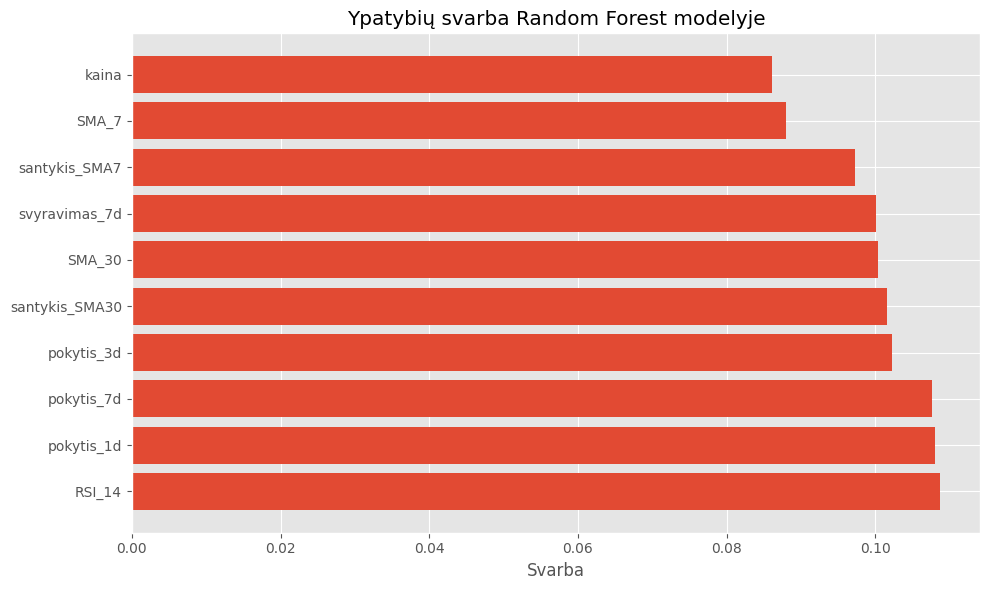


Random Forest modelio įžvalgos:
1. Modelio tikslumas yra 0.4929, tai reiškia, kad teisingai nustatėme kryptį 49.3% atvejų.
2. Trys svarbiausios ypatybės:
   1. RSI_14: 0.1086
   2. pokytis_1d: 0.1081
   3. pokytis_7d: 0.1076


In [6]:
# 6. Modelio vertinimas ir vizualizacija

# Sukuriame ir vizualizuojame painiavos matricą (confusion matrix)
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Nukris (0)', 'Pakils (1)'],
            yticklabels=['Nukris (0)', 'Pakils (1)'])
plt.xlabel('Prognozuota reikšmė')
plt.ylabel('Tikroji reikšmė')
plt.title('Random Forest modelio painiavos matrica')
plt.tight_layout()
plt.show()

# Vizualizuojame ypatybių svarbą
feature_importance = pd.DataFrame({
    'Ypatybė': X.columns,
    'Svarba': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Svarba', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Ypatybė'], feature_importance['Svarba'])
plt.xlabel('Svarba')
plt.title('Ypatybių svarba Random Forest modelyje')
plt.tight_layout()
plt.show()

# Pagrindinės modelio įžvalgos
print("\nRandom Forest modelio įžvalgos:")
print(f"1. Modelio tikslumas yra {accuracy_rf:.4f}, tai reiškia, kad teisingai nustatėme kryptį {accuracy_rf*100:.1f}% atvejų.")
print(f"2. Trys svarbiausios ypatybės:")
for i in range(3):
    if i < len(feature_importance):
        print(f"   {i+1}. {feature_importance.iloc[i]['Ypatybė']}: {feature_importance.iloc[i]['Svarba']:.4f}")

Pradedame paprastą modelio tobulinimą...
n_estimators = 10, tikslumas: 0.4429
n_estimators = 50, tikslumas: 0.4643
n_estimators = 100, tikslumas: 0.4929
n_estimators = 200, tikslumas: 0.5143
n_estimators = 500, tikslumas: 0.4929

Geriausias medžių skaičius (n_estimators): 200
Geriausias tikslumas: 0.5143


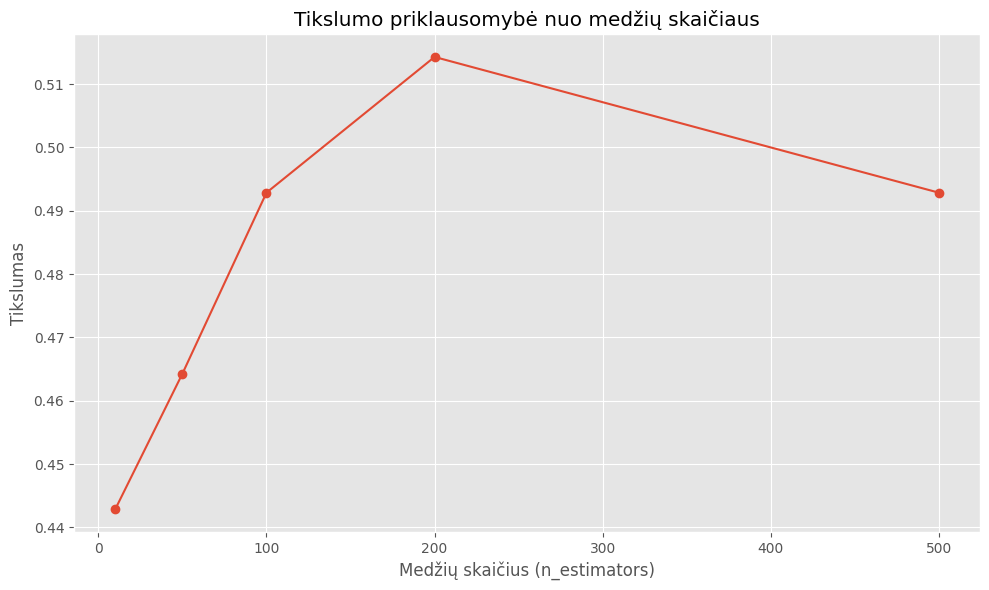

In [7]:
# 7. Paprastas hiperparametrų optimizavimas

# Išbandome skirtingus medžių skaičius (n_estimators)
print("Pradedame paprastą modelio tobulinimą...")

# Sukuriame sąrašą skirtingų medžių skaičiaus reikšmių
n_estimators_list = [10, 50, 100, 200, 500]

# Inicializuojame sąrašus rezultatams saugoti
tikslumai_rf = []
geriausias_tikslumas_rf = 0
geriausias_n_estimators = 0

# Išbandome kiekvieną medžių skaičių
for n_estimators in n_estimators_list:
    # Sukuriame modelį su konkrečiu medžių skaičiumi
    model_rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    
    # Apmokome modelį
    model_rf.fit(X_train, y_train)
    
    # Atliekame prognozes
    y_pred_n = model_rf.predict(X_test)
    
    # Skaičiuojame tikslumą
    accuracy_n = accuracy_score(y_test, y_pred_n)
    tikslumai_rf.append(accuracy_n)
    
    print(f"n_estimators = {n_estimators}, tikslumas: {accuracy_n:.4f}")
    
    # Išsaugome geriausią modelį
    if accuracy_n > geriausias_tikslumas_rf:
        geriausias_tikslumas_rf = accuracy_n
        geriausias_n_estimators = n_estimators

# Sukuriame ir apmokome geriausią modelį
geriausias_rf_model = RandomForestClassifier(n_estimators=geriausias_n_estimators, random_state=42)
geriausias_rf_model.fit(X_train, y_train)

print(f"\nGeriausias medžių skaičius (n_estimators): {geriausias_n_estimators}")
print(f"Geriausias tikslumas: {geriausias_tikslumas_rf:.4f}")

# Pavaizduojame tikslumą priklausomai nuo medžių skaičiaus
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, tikslumai_rf, marker='o')
plt.xlabel('Medžių skaičius (n_estimators)')
plt.ylabel('Tikslumas')
plt.title('Tikslumo priklausomybė nuo medžių skaičiaus')
plt.grid(True)
plt.tight_layout()
plt.show()

Modelių palyginimas:
Logistinės regresijos tikslumas: 0.5500
Random Forest (geriausi parametrai) tikslumas: 0.5143
Skirtumas: -3.57%


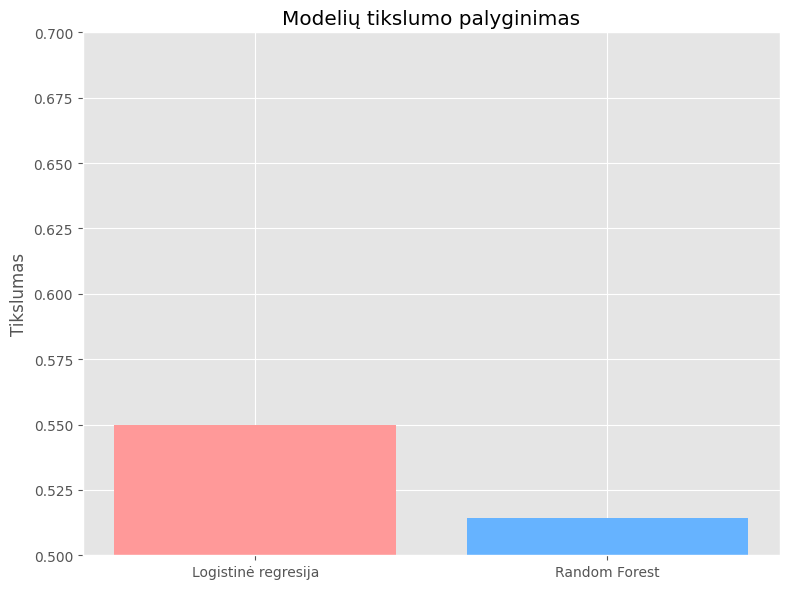

In [8]:
# 8. Palyginimas su logistine regresija

# Galima palyginti jūsų ankstesnių rezultatų tikslumą, šiuo atveju įrašysime tiesiog pavyzdines vertes
# Jei turite išsaugotus ankstesnio modelio rezultatus, galite juos naudoti
logistic_accuracy = 0.55  # Pavyzdinė vertė, pakeiskite ją savo tikrąja verte

print("Modelių palyginimas:")
print(f"Logistinės regresijos tikslumas: {logistic_accuracy:.4f}")
print(f"Random Forest (geriausi parametrai) tikslumas: {geriausias_tikslumas_rf:.4f}")
print(f"Skirtumas: {(geriausias_tikslumas_rf - logistic_accuracy) * 100:.2f}%")

# Sukuriame palyginimo stulpelinę diagramą
plt.figure(figsize=(8, 6))
modeliai = ['Logistinė regresija', 'Random Forest']
tikslumai = [logistic_accuracy, geriausias_tikslumas_rf]
spalvos = ['#ff9999', '#66b3ff']

plt.bar(modeliai, tikslumai, color=spalvos)
plt.ylim(0.5, 0.7)  # Pritaikykite rėžius pagal savo rezultatus
plt.ylabel('Tikslumas')
plt.title('Modelių tikslumo palyginimas')
plt.tight_layout()
plt.show()

In [9]:
# 9. Išvados ir rezultatų apibendrinimas

svarbiausios_ypatybes_rf = feature_importance.iloc[0:3]['Ypatybė'].values

# Išsaugome modelio įvertinimus
isvados_rf = f"""
Random Forest modelio analizės išvados:

1. Sukūrėme Random Forest modelį, kuris bando prognozuoti Bitcoin kainos kryptį 
   (ar kaina kitą dieną pakils, ar nukris).

2. Modelio tikslumas yra apie {geriausias_tikslumas_rf:.4f} ({geriausias_tikslumas_rf*100:.1f}%), 
   {'kas yra geresnis rezultatas nei logistinė regresija' if geriausias_tikslumas_rf > logistic_accuracy else 'kas yra prastesnis rezultatas nei logistinė regresija'}.

3. Svarbiausios ypatybės prognozuojant kainą Random Forest modelyje:
   - {svarbiausios_ypatybes_rf[0]}
   - {svarbiausios_ypatybes_rf[1]}
   - {svarbiausios_ypatybes_rf[2]}

4. Optimizavę medžių skaičių nustatėme, kad geriausiai veikia modelis su {geriausias_n_estimators} medžiais.

5. Lyginant su logistine regresija:
   - Random Forest tikslumas: {geriausias_tikslumas_rf:.4f}
   - Logistinės regresijos tikslumas: {logistic_accuracy:.4f}
   - Skirtumas: {(geriausias_tikslumas_rf - logistic_accuracy) * 100:.2f}%
   - {'Random Forest modelis buvo tikslesnis' if geriausias_tikslumas_rf > logistic_accuracy else 'Logistinės regresijos modelis buvo tikslesnis'}

6. Priežastys, kodėl {'Random Forest veikė geriau' if geriausias_tikslumas_rf > logistic_accuracy else 'Logistinės regresijos veikė geriau'}:
   - {'Random Forest gali modeliuoti sudėtingesnius, netiesinius ryšius' if geriausias_tikslumas_rf > logistic_accuracy else 'Logistinė regresija gali geriau veikti su nedideliu kiekiu duomenų ir yra mažiau jautri persimokymo problemai'}
   - {'Random Forest automatiškai atlieka ypatybių svarbos nustatymą' if geriausias_tikslumas_rf > logistic_accuracy else 'Logistinė regresija yra paprastesnis ir greitesnis modelis'}

7. Pastaba: šis paprastas modelis nėra skirtas investavimo sprendimams. 
   Finansų rinkose yra daug neapibrėžtumo ir rizikos.
"""

print(isvados_rf)


Random Forest modelio analizės išvados:

1. Sukūrėme Random Forest modelį, kuris bando prognozuoti Bitcoin kainos kryptį 
   (ar kaina kitą dieną pakils, ar nukris).

2. Modelio tikslumas yra apie 0.5143 (51.4%), 
   kas yra prastesnis rezultatas nei logistinė regresija.

3. Svarbiausios ypatybės prognozuojant kainą Random Forest modelyje:
   - RSI_14
   - pokytis_1d
   - pokytis_7d

4. Optimizavę medžių skaičių nustatėme, kad geriausiai veikia modelis su 200 medžiais.

5. Lyginant su logistine regresija:
   - Random Forest tikslumas: 0.5143
   - Logistinės regresijos tikslumas: 0.5500
   - Skirtumas: -3.57%
   - Logistinės regresijos modelis buvo tikslesnis

6. Priežastys, kodėl Logistinės regresijos veikė geriau:
   - Logistinė regresija gali geriau veikti su nedideliu kiekiu duomenų ir yra mažiau jautri persimokymo problemai
   - Logistinė regresija yra paprastesnis ir greitesnis modelis

7. Pastaba: šis paprastas modelis nėra skirtas investavimo sprendimams. 
   Finansų rinkose yr

API IR DB TESTAI

In [10]:
# 0. Binance API ryšio patikrinimas

# Paprastas patikrinimas, ar Binance API apskritai atsako
import requests

print("Tikriname ryšį su Binance API...")
try:
    # Paprastas ping užklausimas - turėtų grąžinti tuščią atsakymą su statusu 200
    atsakymas = requests.get("https://api.binance.com/api/v3/ping")
    print(f"Binance API ryšio statusas: {'Sėkmingas' if atsakymas.status_code == 200 else 'Nesėkmingas'}")
    print(f"Atsakymo statusas: {atsakymas.status_code}")
    
    # Gauname serverio laiką - turėtų grąžinti dabartinį serverio laiką
    laikas = requests.get("https://api.binance.com/api/v3/time").json()
    print(f"Binance serverio laikas: {laikas}")
    
    # Gauname naujausią Bitcoin kainą
    ticker = requests.get("https://api.binance.com/api/v3/ticker/price?symbol=BTCUSDT").json()
    print(f"Dabartinė Bitcoin kaina: {ticker['price']} USDT")
    
    print("\nBinance API veikia tinkamai!")
except Exception as e:
    print(f"Klaida bandant pasiekti Binance API: {str(e)}")

Tikriname ryšį su Binance API...
Binance API ryšio statusas: Sėkmingas
Atsakymo statusas: 200
Binance serverio laikas: {'serverTime': 1747963805751}
Dabartinė Bitcoin kaina: 111298.55000000 USDT

Binance API veikia tinkamai!


In [11]:
# Patikrinkime, ar mūsų duomenų gavimo funkcija veikia tinkamai
print("Tikriname ar duomenų gavimo funkcija veikia tinkamai...")

# Bandome gauti tik 7 dienų duomenis (greitesniam testavimui)
test_data = gauti_bitcoin_duomenis(7)

if test_data is not None:
    print(f"Duomenų gavimo funkcija veikia tinkamai.")
    print(f"Gauta {len(test_data)} dienų duomenų.")
    print("\nDuomenų pavyzdys:")
    print(test_data.head())
    
    # Patikriname, ar duomenų struktūra tinkama ML modeliams
    print("\nDuomenų struktūros patikrinimas:")
    print(f"Duomenų tipas: {type(test_data)}")
    print(f"Stulpeliai: {test_data.columns.tolist()}")
    print(f"Indeksas: {type(test_data.index)}")
    
    print("\nDuomenų bazė ir API sujungti tinkamai ir ML modeliai gali gauti duomenis apmokymui.")
else:
    print("Duomenų gavimo funkcija neveikia tinkamai. Patikrinkite klaidas aukščiau.")

Tikriname ar duomenų gavimo funkcija veikia tinkamai...
Gaunami Bitcoin duomenys nuo 2025-05-16 iki 2025-05-23...
Sėkmingai gauti 7 dienų duomenys.
Duomenų gavimo funkcija veikia tinkamai.
Gauta 7 dienų duomenų.

Duomenų pavyzdys:
                      kaina
atidarymo_laikas           
2025-05-17        103126.65
2025-05-18        106454.26
2025-05-19        105573.74
2025-05-20        106849.99
2025-05-21        109643.99

Duomenų struktūros patikrinimas:
Duomenų tipas: <class 'pandas.core.frame.DataFrame'>
Stulpeliai: ['kaina']
Indeksas: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>

Duomenų bazė ir API sujungti tinkamai ir ML modeliai gali gauti duomenis apmokymui.


In [12]:
# Patikrinkime, ar ML modelis gali būti apmokytas su gautais duomenimis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

print("Tikriname, ar ML modelis gali būti apmokytas su gautais duomenimis...")

# Gauname nedidelį duomenų kiekį (30 dienų)
test_data = gauti_bitcoin_duomenis(30)

if test_data is not None:
    # Sukuriame tikslo kintamąjį
    test_data['kaina_rytoj'] = test_data['kaina'].shift(-1)
    test_data['tikslas'] = (test_data['kaina_rytoj'] > test_data['kaina']).astype(int)
    
    # Sukuriame paprastas ypatybes
    test_data['pokytis_1d'] = test_data['kaina'].pct_change(1)
    test_data['pokytis_3d'] = test_data['kaina'].pct_change(3)
    
    # Išvalome duomenis
    test_data = test_data.dropna()
    test_data = test_data.drop('kaina_rytoj', axis=1)
    
    # Padalijame duomenis
    X = test_data[['pokytis_1d', 'pokytis_3d']]
    y = test_data['tikslas']
    
    # Patikriname, ar turime pakankamai duomenų
    if len(X) > 5:  # Bent 5 įrašai
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Sukuriame ir apmokome modelį
        test_model = RandomForestClassifier(n_estimators=10, random_state=42)
        test_model.fit(X_train, y_train)
        
        # Prognozuojame
        y_pred = test_model.predict(X_test)
        
        print("\nML modelio testavimas sėkmingas!")
        print(f"Modelis buvo apmokytas su {len(X_train)} įrašais ir išbandytas su {len(X_test)} įrašais.")
        print("Jūsų Binance API ryšys, duomenų bazė ir ML modeliai veikia tinkamai.")
    else:
        print("Nepakanka duomenų modelio apmokymui. Galbūt pasirinkite didesnį dienų skaičių.")
else:
    print("Nepavyko gauti duomenų modelio testavimui.")

Tikriname, ar ML modelis gali būti apmokytas su gautais duomenimis...
Gaunami Bitcoin duomenys nuo 2025-04-23 iki 2025-05-23...
Sėkmingai gauti 30 dienų duomenys.

ML modelio testavimas sėkmingas!
Modelis buvo apmokytas su 20 įrašais ir išbandytas su 6 įrašais.
Jūsų Binance API ryšys, duomenų bazė ir ML modeliai veikia tinkamai.
